#  Algorithmic Biases in Computer Vision: How CelebA Encodes and Reproduces Gender Stereotypes in Appearance


Large-scale facial datasets such as CelebA are widely used to train models for appearance-related tasks in computer vision, yet the cultural biases embedded within them remain insufficiently examined. This study investigates how systemic biases in media representation are reflected in CelebA’s attribute structure and carried through to algorithmic predictions.

---





To audit image datasets and implementation of subsequent model behaviour, the following supervised & unsupervised learning alongside Explainable AI (XAI) were used.

*   Hierarchical Clustering with Dendrogram
*   T-Distributed Stochastic Neighbor Embedding (t-sne)
*   Logistic Regression
*   eXtreme Gradient Boosting (XGBoost)
*   TreeSHAP (SHapley Additive exPlanations)







## 0. Set-up


---



In [1]:
pip install shap

In [2]:
pip install adjustText

In [3]:
!pip install --quiet optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/400.9 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/247.0 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 14.2 MB/s eta 0:00:00


In [17]:
!pip install patsy

In [4]:
# Save Kaggle Token to correct directory
import os
import json

api_token = {"username": "uniwmak12", "key": "009b11a3b7d2d8984fe4baac7b90a791"}
kaggle_dir = "/root/.config/kaggle"

os.makedirs(kaggle_dir, exist_ok=True)
with open(os.path.join(kaggle_dir, "kaggle.json"), "w") as f:
     json.dump(api_token, f)
os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)

## 1. Data loading and preprocessing


---



In [23]:
import matplotlib.pyplot as plt
import os, zipfile, math, numpy as np
import pandas as pd
import seaborn as sns
import math
import xgboost as xgb
import matplotlib as mpl
import optuna
import shap, matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import patsy

from PIL import Image
from kaggle.api.kaggle_api_extended import KaggleApi
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.spatial.distance import squareform
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.contrast import ContrastResults
from sklearn.manifold import MDS, TSNE
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier
from scipy.stats import chi2
from pathlib import Path
from adjustText import adjust_text
from tqdm import tqdm

In [6]:
# Download and extract dataset
api = KaggleApi()
api.authenticate()

download_dir = "celeba_data"
os.makedirs(download_dir, exist_ok=True)

api.dataset_download_files('jessicali9530/celeba-dataset', path=download_dir, unzip=True)

# Load attribute CSV
attr_path = os.path.join(download_dir, "list_attr_celeba.csv")
df = pd.read_csv(attr_path)

# Convert attributes from {-1, 1} to {0, 1}
df = df.replace({-1: 0, 1: 1})

# Prepare features and label
target_label = "Attractive"
feature_columns = [col for col in df.columns if col not in ["image_id", target_label]]

X = df[feature_columns]
y = df[target_label]

# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset


In [7]:
download_dir = Path("celeba_data")

img_dir = None
for cand in [
    download_dir / "img_align_celeba",
    download_dir / "img_align_celeba" / "img_align_celeba",
]:
    if (cand / "000001.jpg").exists():
        img_dir = cand
        break

if img_dir is None:
    import zipfile, sys
    zip_path = download_dir / "img_align_celeba.zip"
    print("Extracting", zip_path.name, "…")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(download_dir)
    img_dir = download_dir / "img_align_celeba" / "img_align_celeba"
print("Using image folder:", img_dir)

Using image folder: celeba_data/img_align_celeba/img_align_celeba


## 2. Study 1 ㅡ Datasets Auditing


---



### Step 1 : Hierarchical Clustering with Dendrogram

Conducted hierarchical clustering of 202,599 celebrity images. The outcome identifies seven latent trait bundles reflecting societal archetypes: performative femininity (youth, makeup, adornment) and professional masculinity (aging, facial hair, formalwear). Elbow point indecates optimal number of cluster (= 7)

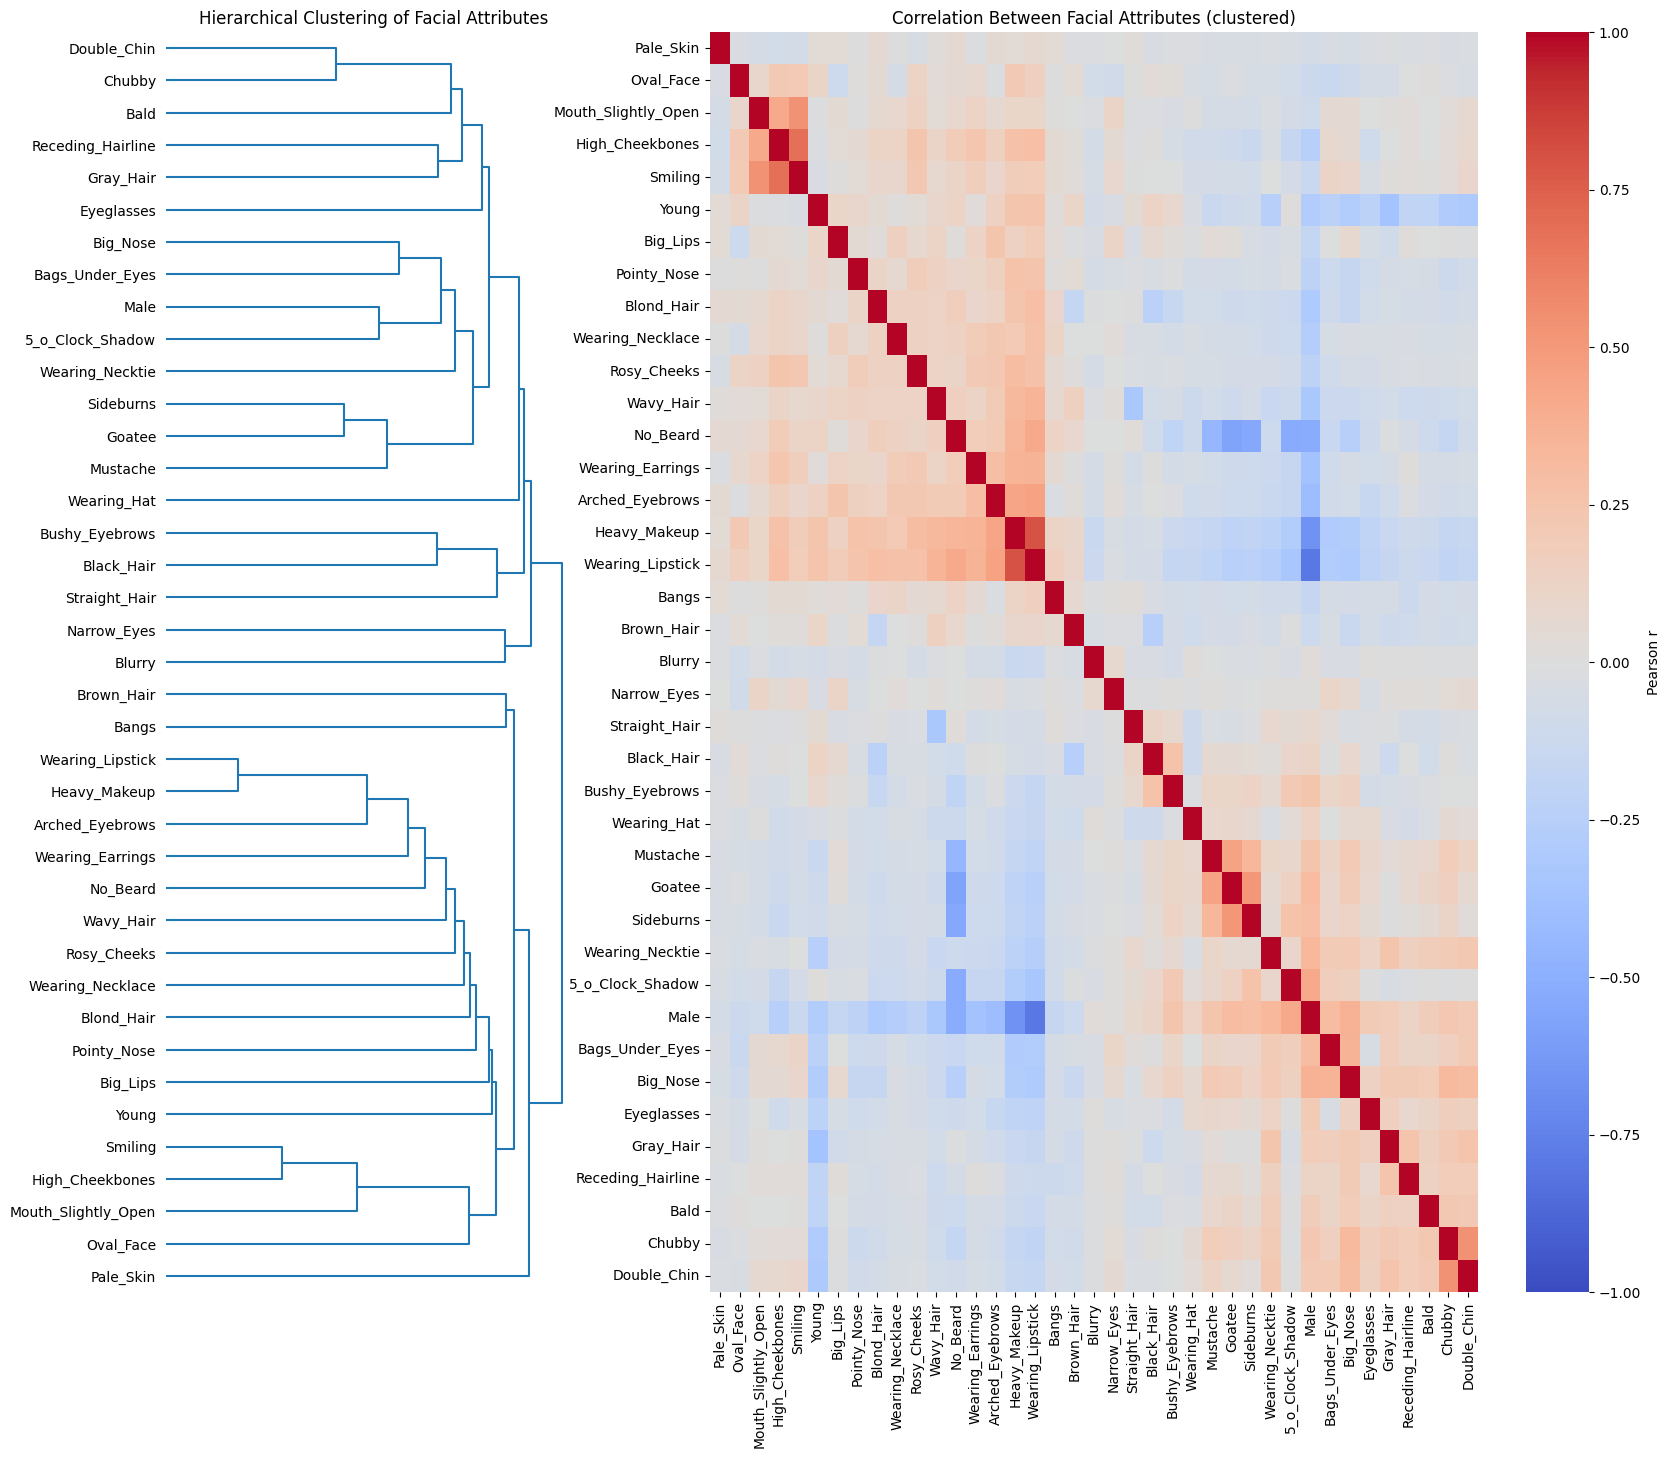


Attribute → Cluster label
 Arched_Eyebrows        1
Big_Lips               1
Blond_Hair             1
Rosy_Cheeks            1
Mouth_Slightly_Open    1
No_Beard               1
High_Cheekbones        1
Heavy_Makeup           1
Oval_Face              1
Pointy_Nose            1
Smiling                1
Young                  1
Wearing_Necklace       1
Wearing_Lipstick       1
Wearing_Earrings       1
Wavy_Hair              1
Brown_Hair             2
Bangs                  2
Pale_Skin              3
Narrow_Eyes            4
Blurry                 4
Black_Hair             5
Straight_Hair          5
Bushy_Eyebrows         5
Goatee                 6
Eyeglasses             6
Double_Chin            6
Chubby                 6
Bald                   6
Bags_Under_Eyes        6
5_o_Clock_Shadow       6
Big_Nose               6
Sideburns              6
Receding_Hairline      6
Male                   6
Mustache               6
Gray_Hair              6
Wearing_Necktie        6
Wearing_Hat           

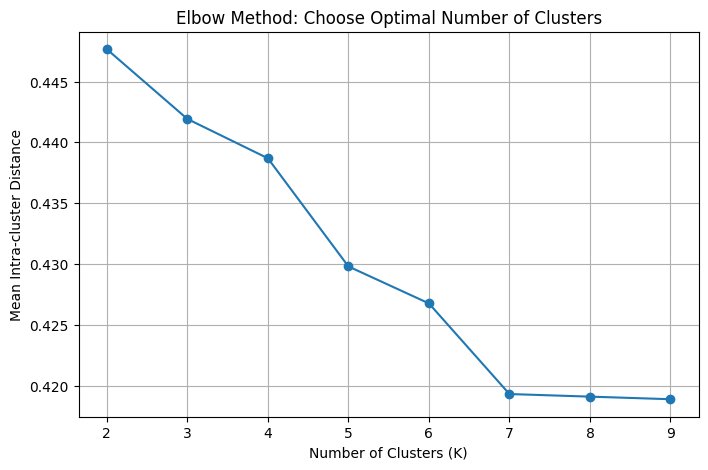

In [8]:
attribute_list = [col for col in df.columns if col not in ["Attractive", "image_id"]]

# Correlation matrix of the binary attributes
corr = df[attribute_list].corr()

# Turn correlation into a distance matrix
dist_condensed = squareform((1 - corr.values) / 2)

# Hierarchical clustering
link = linkage(dist_condensed, method='average')

# Plot dendrogram
fig = plt.figure(figsize=(16, 14))
ax_d = fig.add_axes([0.01, 0.05, 0.26, 0.9])
dendro = dendrogram(
    link,
    labels=corr.index,
    orientation='right',
    color_threshold=0,
    leaf_font_size=10
)
ax_d.set_xticks([])
ax_d.set_xlabel('')
ax_d.set_ylabel('')
ax_d.set_title("Hierarchical Clustering of Facial Attributes")

for spine in ax_d.spines.values():
    spine.set_visible(False)

# Reorder the correlation matrix to follow the dendrogram
order = dendro['leaves']
corr_reordered = corr.iloc[order, order]

# Clustered heat-map
ax_h = fig.add_axes([0.35, 0.05, 0.6, 0.9])
sns.heatmap(
    corr_reordered,
    cmap='coolwarm',
    center=0,
    vmin=-1, vmax=1,
    cbar_kws={'label': 'Pearson r'},
    ax=ax_h,
    xticklabels=True, yticklabels=True
)
ax_h.set_title("Correlation Between Facial Attributes (clustered)")
plt.show()

# Cut the dendrogram into K clusters
clusters = fcluster(link, t=7, criterion='maxclust')
cluster_map = pd.Series(clusters, index=corr.index)
print("\nAttribute → Cluster label\n", cluster_map.sort_values())

# Elbow Method for choosing optimal K
intra_cluster_dists = []
ks = list(range(2, 10))

for k in ks:
    cluster_k = fcluster(link, t=k, criterion='maxclust')
    mask = np.array([cluster_k[i] == cluster_k[j] for i in range(len(cluster_k)) for j in range(i + 1, len(cluster_k))])
    intra_d = dist_condensed[mask]
    if len(intra_d) > 0:
        intra_cluster_dists.append(np.mean(intra_d))
    else:
        intra_cluster_dists.append(np.nan)

plt.figure(figsize=(8, 5))
plt.plot(ks, intra_cluster_dists, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Mean Intra-cluster Distance")
plt.title("Elbow Method: Choose Optimal Number of Clusters")
plt.grid(True)
plt.show()

In [10]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
corr_df = corr.round(3)
corr_df

,5_o_Clock_Shadow,Arched_Eyebrows,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
5_o_Clock_Shadow,1.000,-0.159,0.168,0.006,-0.089,-0.044,0.152,0.101,-0.133,-0.033,-0.012,0.218,-0.010,0.003,0.007,0.144,-0.044,-0.281,-0.161,0.418,-0.066,0.092,0.011,-0.527,-0.085,-0.040,-0.024,-0.022,-0.090,0.259,-0.068,0.052,-0.124,-0.162,0.034,-0.334,-0.116,0.098,0.015
Arched_Eyebrows,-0.159,1.000,-0.092,-0.070,-0.028,0.243,-0.084,-0.001,0.127,-0.076,0.018,-0.018,-0.089,-0.078,-0.149,-0.113,-0.099,0.440,0.156,-0.408,0.067,-0.086,0.024,0.203,-0.013,0.048,0.153,-0.017,0.224,-0.116,0.094,-0.054,0.201,0.295,-0.100,0.460,0.220,-0.133,0.147
Bags_Under_Eyes,0.168,-0.092,1.000,0.116,-0.058,-0.006,0.362,0.003,-0.107,-0.033,-0.046,0.107,0.157,0.196,-0.042,0.095,0.172,-0.293,0.073,0.301,0.059,0.110,0.107,-0.147,-0.136,-0.033,-0.114,0.117,-0.094,0.100,0.113,0.024,-0.127,-0.097,-0.006,-0.284,-0.053,0.197,-0.231
Bald,0.006,-0.070,0.116,1.000,-0.064,-0.004,0.180,-0.080,-0.063,-0.009,-0.077,-0.020,0.224,0.213,0.109,0.115,0.151,-0.120,-0.002,0.178,-0.000,0.080,0.012,-0.116,0.011,-0.023,-0.056,0.140,-0.037,0.059,0.009,-0.072,-0.103,-0.061,-0.031,-0.143,-0.050,0.177,-0.196
Bangs,-0.089,-0.028,-0.058,-0.064,1.000,0.035,-0.069,-0.034,0.099,-0.009,0.069,-0.073,-0.084,-0.070,-0.059,-0.086,-0.062,0.120,0.053,-0.163,0.009,-0.067,0.013,0.132,0.002,0.042,0.011,-0.124,0.061,-0.073,0.052,0.020,0.068,0.058,-0.080,0.163,0.114,-0.093,0.018
Big_Lips,-0.044,0.243,-0.006,-0.004,0.035,1.000,0.077,0.067,0.024,-0.037,-0.015,0.021,0.008,-0.010,-0.051,0.019,-0.088,0.147,0.045,-0.167,0.049,0.031,0.114,0.023,-0.112,0.039,0.053,0.021,0.077,-0.040,0.013,-0.037,0.120,0.127,-0.013,0.195,0.150,-0.068,0.108
Big_Nose,0.152,-0.084,0.362,0.180,-0.069,0.077,1.000,0.081,-0.158,-0.038,-0.133,0.141,0.314,0.298,0.140,0.194,0.196,-0.278,0.059,0.369,0.059,0.208,0.070,-0.254,-0.106,-0.051,-0.159,0.202,-0.055,0.132,0.101,-0.029,-0.132,-0.058,0.066,-0.304,-0.036,0.205,-0.284
Black_Hair,0.101,-0.001,0.003,-0.080,-0.034,0.067,0.081,1.000,-0.234,-0.038,-0.252,0.258,0.010,-0.028,-0.016,0.059,-0.117,-0.049,0.008,0.116,-0.023,0.064,-0.011,-0.099,0.032,-0.039,-0.047,-0.000,-0.040,0.043,-0.003,0.112,-0.085,0.002,-0.104,-0.067,-0.043,0.023,0.121
Blond_Hair,-0.133,0.127,-0.107,-0.063,0.099,0.024,-0.158,-0.234,1.000,-0.011,-0.170,-0.150,-0.090,-0.077,-0.081,-0.103,-0.052,0.247,0.121,-0.303,0.070,-0.086,-0.001,0.171,0.050,0.058,0.115,-0.070,0.142,-0.096,0.090,0.005,0.128,0.095,-0.083,0.282,0.144,-0.106,0.052
Blurry,-0.033,-0.076,-0.033,-0.009,-0.009,-0.037,-0.038,-0.038,-0.011,1.000,-0.040,-0.065,-0.009,-0.012,0.014,-0.026,0.008,-0.140,-0.077,0.024,-0.017,-0.005,0.071,-0.004,-0.083,-0.020,-0.055,0.007,-0.057,-0.025,-0.053,-0.037,-0.020,-0.058,0.016,-0.127,-0.004,-0.015,-0.066


In [11]:
# Put every attribute into its cluster bucket
cluster_df = (
    pd.Series(clusters, index=corr.index, name='Cluster')
      .reset_index()
      .rename(columns={'index':'Attribute'})
      .sort_values('Cluster')
)

for k, g in cluster_df.groupby('Cluster'):
    print(f"\n★ Cluster {k} ({len(g)} attributes)")
    print("  " + ", ".join(g['Attribute'].tolist()))


★ Cluster 1 (16 attributes)
  Arched_Eyebrows, Big_Lips, Blond_Hair, Rosy_Cheeks, Mouth_Slightly_Open, No_Beard, High_Cheekbones, Heavy_Makeup, Oval_Face, Pointy_Nose, Smiling, Young, Wearing_Necklace, Wearing_Lipstick, Wearing_Earrings, Wavy_Hair

★ Cluster 2 (2 attributes)
  Brown_Hair, Bangs

★ Cluster 3 (1 attributes)
  Pale_Skin

★ Cluster 4 (2 attributes)
  Narrow_Eyes, Blurry

★ Cluster 5 (3 attributes)
  Black_Hair, Straight_Hair, Bushy_Eyebrows

★ Cluster 6 (14 attributes)
  Goatee, Eyeglasses, Double_Chin, Chubby, Bald, Bags_Under_Eyes, 5_o_Clock_Shadow, Big_Nose, Sideburns, Receding_Hairline, Male, Mustache, Gray_Hair, Wearing_Necktie

★ Cluster 7 (1 attributes)
  Wearing_Hat


### Step 2 : T-Distributed Stochastic Neighbor Embedding


To visualise spatial relations of attributes within clusters, a t-SNE projection of the full Pearson-distance matrix was used.

In [ ]:
# Compute distance matrix from correlation
corr = df[attribute_list].corr()
dist_matrix = (1 - corr.values) / 2
dist_condensed = squareform(dist_matrix)

# Hierarchical clustering
link = linkage(dist_condensed, method='average')
clusters = fcluster(link, t=7, criterion='maxclust')

# t-SNE with precomputed distance
tsne = TSNE(n_components=2, metric='precomputed', init='random', perplexity=5, random_state=42)
embedding = tsne.fit_transform(dist_matrix)

# Prepare DataFrame for plotting
cluster_df = pd.DataFrame({
    'x': embedding[:, 0],
    'y': embedding[:, 1],
    'Attribute': corr.columns,
    'Cluster': clusters
})

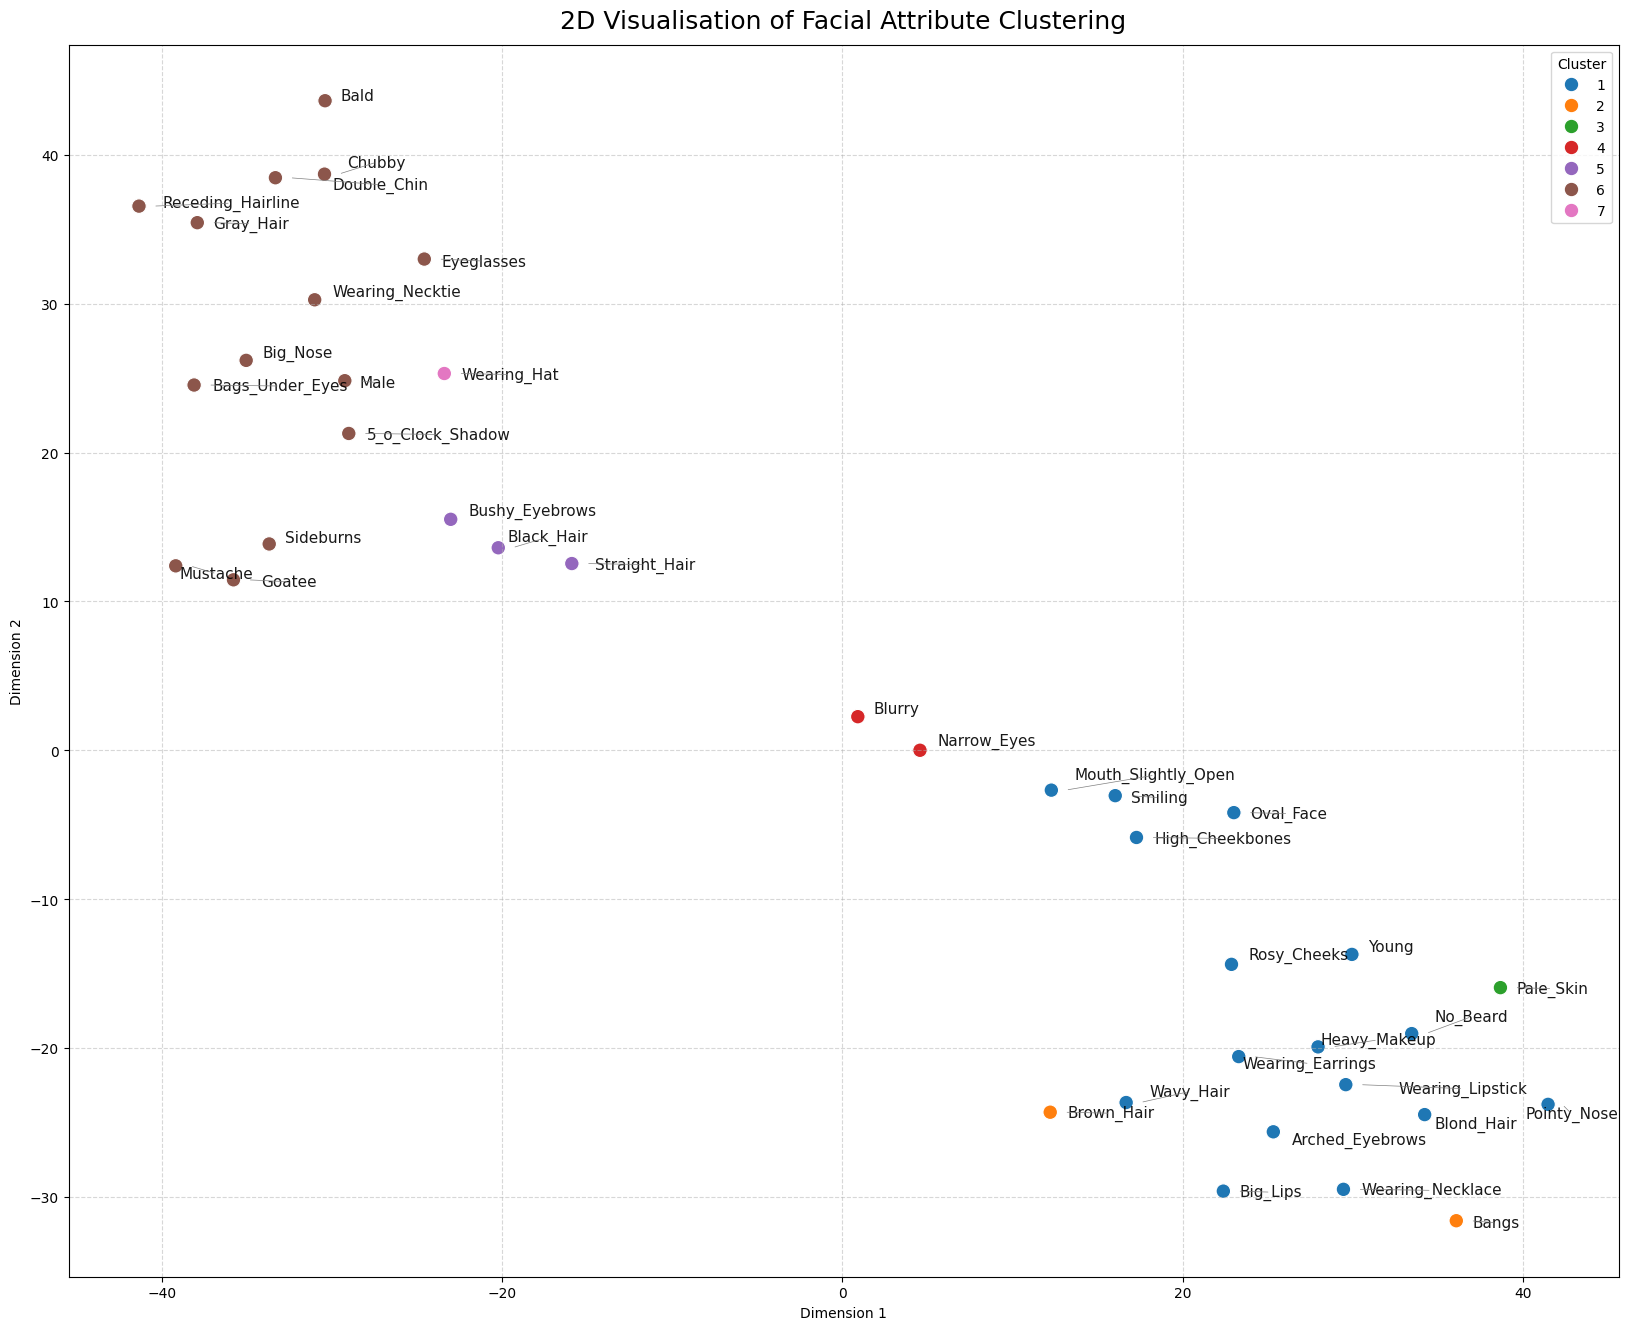

In [ ]:
plt.figure(figsize=(20, 16))
sns.scatterplot(data=cluster_df, x="x", y="y",
                hue="Cluster", palette="tab10", s=110)

# Add text labels _first_ at the exact point positions
x_offset = 0.01 * (cluster_df['x'].max() - cluster_df['x'].min())

texts = []
for _, row in cluster_df.iterrows():
    txt = plt.text(row["x"] + x_offset,
                   row["y"],
                   row["Attribute"],
                   fontsize=11 , alpha=0.9,
                   ha='left', va='center')
    texts.append(txt)

# Run collision‑avoidance
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='-', color='grey', lw=.5),
    expand_text=(1.4, 1.45),
    expand_points=(1.45, 1.45)
)

plt.title("2D Visualisation of Facial Attribute Clustering",
          fontsize=18,
          pad=12)
plt.xlabel("Dimension 1"); plt.ylabel("Dimension 2")
plt.legend(title='Cluster')
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### Step 3 : Images Allocation for Each Cluster

Images are allocated by dominant features and measures average attractiveness scores in each cluster. This is inspired by Cue‑integration theory (Oosterhof & Todorov, 2008), where observers evaluate faces by combining multiple diagnostic signals rather than by inspecting isolated traits.

In [13]:
# Compute one ratio column per cluster
ratio_cols = {}

for k, g in cluster_df.groupby('Cluster'):
    attrs_k = g['Attribute'].tolist()
    col     = f'ratio_{k}'
    df[col] = df[attrs_k].mean(axis=1)
    ratio_cols[k] = col

# Turn the continuous profile into one label
def assign_cluster_by_ratio(row, ratio_cols):
    ratios = row[ratio_cols]
    if (ratios > 0).any():
        best = ratios.idxmax()
        return int(best.split('_')[1])
    return np.nan

df['Cluster'] = df.apply(
    assign_cluster_by_ratio, axis=1, ratio_cols=list(ratio_cols.values())
)

# Analyse attractiveness
cluster_attractiveness = (
    df.groupby('Cluster')['Attractive']
      .agg(['mean', 'count'])
      .reset_index()
)

gender_cluster_attractiveness = (
    df.groupby(['Cluster', 'Male'])['Attractive']
      .agg(['mean', 'count'])
      .reset_index()
)

print("Attractiveness by Cluster (max-ratio label):")
print(cluster_attractiveness)

print("\nAttractiveness by Cluster and Gender:")
print(gender_cluster_attractiveness)

Attractiveness by Cluster (max-ratio label):
   Cluster      mean  count
0        1  0.698401  78190
1        2  0.525863  37177
2        3  0.713888   8259
3        4  0.173162  12959
4        5  0.461699  38850
5        6  0.098643  17761
6        7  0.196320   9403

Attractiveness by Cluster and Gender:
    Cluster  Male      mean  count
0         1     0  0.746719  70033
1         1     1  0.283560   8157
2         2     0  0.603681  22656
3         2     1  0.404449  14521
4         3     0  0.779266   6347
5         3     1  0.496862   1912
6         4     0  0.270027   5555
7         4     1  0.100486   7404
8         5     0  0.641779  10728
9         5     1  0.393002  28122
10        6     0  0.058824    119
11        6     1  0.098912  17642
12        7     0  0.346168   2727
13        7     1  0.135111   6676


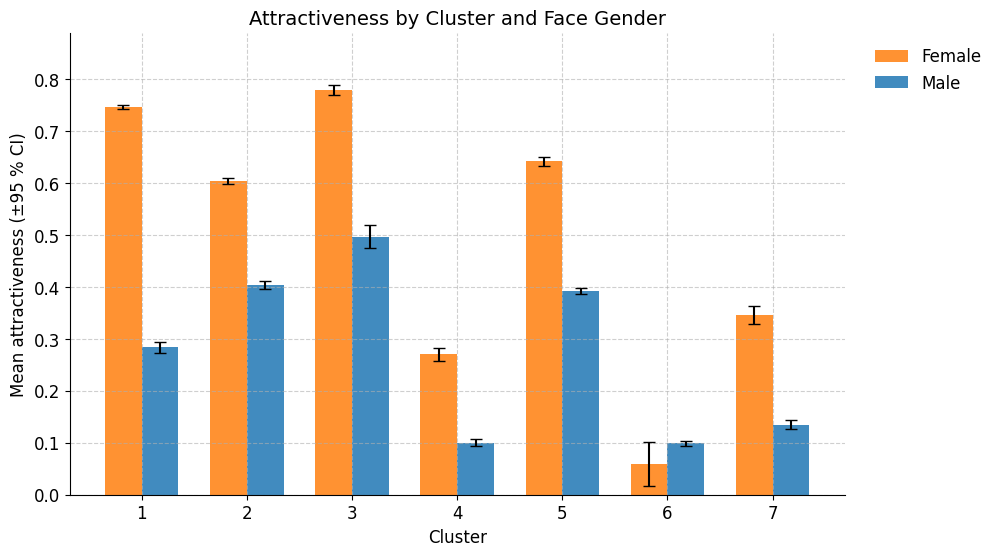

In [14]:
gc = gender_cluster_attractiveness.rename(columns={"mean": "Mean",
                                                   "count": "N"}).copy()
z = 1.96
gc["SE"] = np.sqrt(gc["Mean"] * (1 - gc["Mean"]) / gc["N"])

clusters = sorted(gc["Cluster"].unique())
x        = np.arange(len(clusters))
width    = 0.35

female = gc[gc["Male"] == 0].set_index("Cluster").loc[clusters]
male   = gc[gc["Male"] == 1].set_index("Cluster").loc[clusters]

# Global Matplotlib rcParams tweaks
mpl.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.6,
})

fig, ax = plt.subplots(figsize=(10, 6))

bars_f = ax.bar(
    x - width/2,
    female["Mean"],
    width,
    yerr=z * female["SE"],
    capsize=4,
    label="Female",
    alpha=0.85,
    color="tab:orange",
)

bars_m = ax.bar(
    x + width/2,
    male["Mean"],
    width,
    yerr=z * male["SE"],
    capsize=4,
    label="Male",
    alpha=0.85,
    color="tab:blue",
)

ax.set_xticks(x)
ax.set_xticklabels(clusters)
ax.set_xlabel("Cluster")
ax.set_ylabel("Mean attractiveness (±95 % CI)")
ax.set_title("Attractiveness by Cluster and Face Gender")
ax.legend(frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left")

ax.set_ylim(0, max(gc["Mean"] + z*gc["SE"]) + 0.1)
plt.show()

In [ ]:
df_model = df.dropna(subset=["Cluster", "Attractive", "Male"]).copy()
df_model["Cluster"] = df_model["Cluster"].astype("category")

# Logistic regression with interaction
model = smf.logit("Attractive ~ C(Cluster) * Male", data=df_model).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.571588
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             Attractive   No. Observations:               202599
Model:                          Logit   Df Residuals:                   202585
Method:                           MLE   Df Model:                           13
Date:                Fri, 01 Aug 2025   Pseudo R-squ.:                  0.1750
Time:                        11:17:15   Log-Likelihood:            -1.1580e+05
converged:                       True   LL-Null:                   -1.4037e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.0812      0.009    124.432      0.000       1.064       1.098

In [ ]:
# Wald test
R = np.eye(len(model.params))
wald = model.wald_test(R)
print(wald)

<Wald test (chi2): statistic=[[37196.69751057]], p-value=0.0, df_denom=14>


In [ ]:
# P-values
print(model.pvalues.apply(lambda p: f"{p:.2e}"))

Intercept                0.00e+00
C(Cluster)[T.2]          0.00e+00
C(Cluster)[T.3]          1.05e-08
C(Cluster)[T.4]          0.00e+00
C(Cluster)[T.5]         3.37e-114
C(Cluster)[T.6]          4.63e-23
C(Cluster)[T.7]          0.00e+00
Male                     0.00e+00
C(Cluster)[T.2]:Male    1.47e-274
C(Cluster)[T.3]:Male     1.19e-33
C(Cluster)[T.4]:Male     3.12e-48
C(Cluster)[T.5]:Male    6.59e-175
C(Cluster)[T.6]:Male     4.98e-11
C(Cluster)[T.7]:Male     1.50e-39
dtype: object


In [21]:
# Calculate VIF
y, X = patsy.dmatrices("Attractive ~ C(Cluster) * Male", data=df_model, return_type="dataframe")

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                 feature         VIF
0              Intercept    2.892908
1        C(Cluster)[T.2]    1.773261
2        C(Cluster)[T.3]    1.361322
3        C(Cluster)[T.4]    2.356841
4        C(Cluster)[T.5]    3.375302
5        C(Cluster)[T.6]  136.399175
6        C(Cluster)[T.7]    3.416112
7                   Male    6.740420
8   C(Cluster)[T.2]:Male    3.368403
9   C(Cluster)[T.3]:Male    1.548196
10  C(Cluster)[T.4]:Male    3.223972
11  C(Cluster)[T.5]:Male    6.433556
12  C(Cluster)[T.6]:Male  138.459910
13  C(Cluster)[T.7]:Male    4.218144


In [ ]:
# Build cluster to list of image_ids
cluster_to_imgs = {
    k: grp["image_id"].tolist()
    for k, grp in df.dropna(subset=["Cluster"]).groupby("Cluster")
}

for k, ids in cluster_to_imgs.items():
    print(f"Cluster {k}: {len(ids):,} faces to average")

# Average each list
size   = (128, 128)
outdir = Path("cluster_averages_ratio"); outdir.mkdir(exist_ok=True)

def load_face(path, size=size):
    with Image.open(path) as im:
        return np.asarray(im.resize(size, Image.LANCZOS), np.float32) / 255.

for k, ids in sorted(cluster_to_imgs.items()):
    if not ids:
        print(f"Cluster {k}: empty, skipped")
        continue

    acc = np.zeros((size[1], size[0], 3), np.float64)   # H×W×3
    for img_id in tqdm(ids, desc=f"Cluster {k}", unit="img"):
        fp = img_dir / img_id
        if not fp.exists():
            continue
        try:
            acc += load_face(fp)
        except Exception:
            continue

    acc /= len(ids)
    Image.fromarray((acc * 255).clip(0, 255).astype(np.uint8)) \
         .save(outdir / f"cluster_{k}_mean.jpg")
    print(f"Cluster {k}: saved average from {len(ids):,} faces ✓")

Cluster 1: 78,190 faces to average
Cluster 2: 37,177 faces to average
Cluster 3: 8,259 faces to average
Cluster 4: 12,959 faces to average
Cluster 5: 38,850 faces to average
Cluster 6: 17,761 faces to average
Cluster 7: 9,403 faces to average


Cluster 1: 100%|██████████| 78190/78190 [02:24<00:00, 541.83img/s]


Cluster 1: saved average from 78,190 faces ✓


Cluster 2: 100%|██████████| 37177/37177 [01:08<00:00, 542.16img/s]


Cluster 2: saved average from 37,177 faces ✓


Cluster 3: 100%|██████████| 8259/8259 [00:15<00:00, 534.64img/s]


Cluster 3: saved average from 8,259 faces ✓


Cluster 4: 100%|██████████| 12959/12959 [00:23<00:00, 547.74img/s]


Cluster 4: saved average from 12,959 faces ✓


Cluster 5: 100%|██████████| 38850/38850 [01:11<00:00, 546.83img/s]


Cluster 5: saved average from 38,850 faces ✓


Cluster 6: 100%|██████████| 17761/17761 [00:32<00:00, 553.10img/s]


Cluster 6: saved average from 17,761 faces ✓


Cluster 7: 100%|██████████| 9403/9403 [00:16<00:00, 562.92img/s]

Cluster 7: saved average from 9,403 faces ✓


### Step 4 : Average Images for Each Cluster

For visual inspection, average images, summing up each pixel value divided by its number, have been presented.

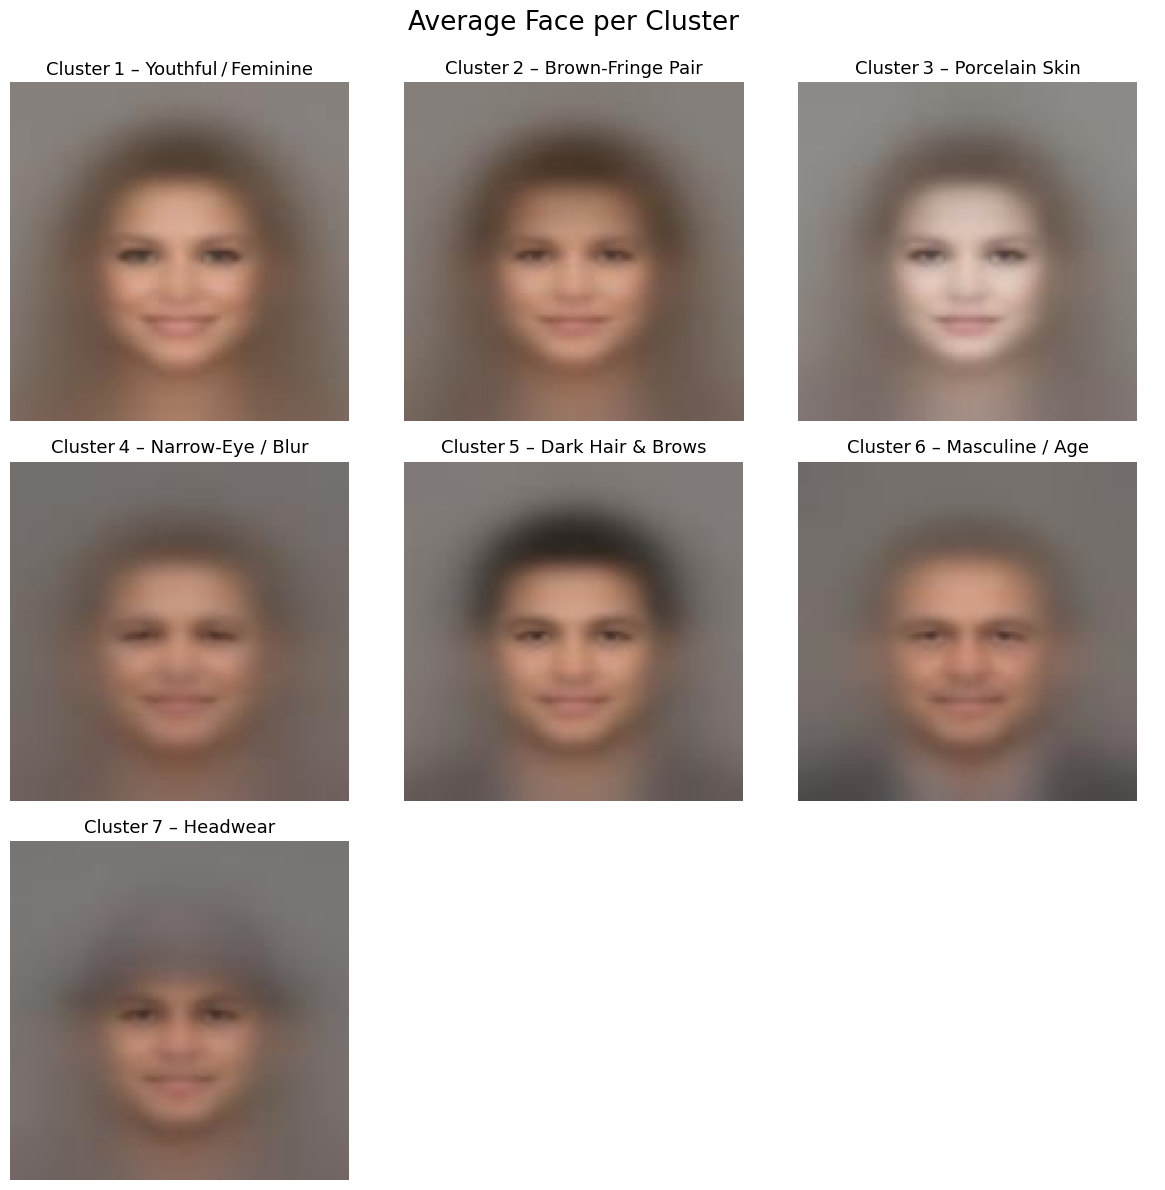

In [ ]:
# Descriptive labels for the legend / titles
cluster_titles = {
    1: "Cluster 1 – Youthful / Feminine",
    2: "Cluster 2 – Brown‑Fringe Pair",
    3: "Cluster 3 – Porcelain Skin",
    4: "Cluster 4 – Narrow‑Eye / Blur",
    5: "Cluster 5 – Dark Hair & Brows",
    6: "Cluster 6 – Masculine / Age",
    7: "Cluster 7 – Headwear"
}

# Collect existing average files
mean_files = sorted(outdir.glob("cluster_*_mean.jpg"))
n = len(mean_files)

cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.ravel()

for ax in axes:
    ax.axis("off")

for idx, fp in enumerate(mean_files):
    # Cluster number from filename "cluster_{k}_mean.jpg"
    k = int(fp.stem.split("_")[1])
    img = Image.open(fp)
    axes[idx].imshow(img)
    axes[idx].set_title(cluster_titles.get(k, f"Cluster {k}"),
                        fontsize=13, pad=6)
    axes[idx].axis("off")

plt.suptitle("Average Face per Cluster", fontsize=19, y=0.99)
plt.tight_layout()
plt.show()

## 3. Study 2 ㅡ Auditing Model Behaviour through XAI


---



Study 2 trains XGBoost classifier and analyses feature contributions using SHAP values separately for female and male subsets.



### Step 1 : Hyperparameter Tuning for XGBoost

---



Hyperparameter optimisation was conducted using **Optuna**, a modern framework for efficient and scalable **hyperparameter search** (Akiba et al., 2019). Eighty trials of Bayesian optimisation were conducted, exploring parameters such as tree depth, minimum node weight, learning rate, number of boosting rounds, and sampling ratios for observations and features.

In [26]:
def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "device": "cuda",

        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth":      trial.suggest_int("max_depth", 2, 8),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "subsample":        trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma":            trial.suggest_float("gamma", 0.0, 2.0),

        # Set low slightly > 0 when log=True
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 5.0, log=True),
        "reg_alpha":  trial.suggest_float("reg_alpha",  1e-3, 2.0, log=True),

        "n_estimators": trial.suggest_int("n_estimators", 200, 2000),
    }
    model = XGBClassifier(**params, random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(model, X_train, y_train,
                           cv=cv, scoring="roc_auc", n_jobs=-1).mean()


study = optuna.create_study(direction="maximize", study_name="xgb_tune")
study.optimize(objective, n_trials=80, show_progress_bar=True)

print("Best value:", study.best_value)
print("Best params:", study.best_params)

[I 2025-08-23 03:59:00,302] A new study created in memory with name: xgb_tune


  0%|          | 0/80 [00:00<?, ?it/s]

[I 2025-08-23 03:59:15,479] Trial 0 finished with value: 0.8765642451365794 and parameters: {'learning_rate': 0.0165666078799202, 'max_depth': 5, 'min_child_weight': 20, 'subsample': 0.8546235841680088, 'colsample_bytree': 0.870178999400394, 'gamma': 1.3057790140641337, 'reg_lambda': 0.23258622269985954, 'reg_alpha': 0.005900488330898431, 'n_estimators': 384}. Best is trial 0 with value: 0.8765642451365794.
[I 2025-08-23 03:59:43,456] Trial 1 finished with value: 0.8795396058480989 and parameters: {'learning_rate': 0.06816043715892127, 'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.5211115573422183, 'colsample_bytree': 0.6951613562545361, 'gamma': 1.4729905104321124, 'reg_lambda': 0.34398943188142683, 'reg_alpha': 0.3318512105942485, 'n_estimators': 1859}. Best is trial 1 with value: 0.8795396058480989.
[I 2025-08-23 03:59:55,504] Trial 2 finished with value: 0.8784643860144937 and parameters: {'learning_rate': 0.028115626914819905, 'max_depth': 3, 'min_child_weight': 5, 'subsam

### Step 2 : Model Performance

---

Calculated precision, recall, f1-score, and accuracy to measure model performance.


In [27]:
# Take Optuna’s best hyperparams
best = study.best_params.copy()
best.update(
    dict(
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        device="cuda",
        n_estimators=6000
    )
)

# Early‑stopping split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15,
    stratify=y_train, random_state=42
)

# Final all‑gender model with early stopping
final_model = XGBClassifier(
    **best,
    random_state=42,
    early_stopping_rounds=100
)

final_model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print(f"Stopped at tree {final_model.best_iteration}  "
      f"(val AUC = {final_model.best_score:.4f})")

y_pred  = final_model.predict(X_test)
y_score = final_model.predict_proba(X_test)[:, 1]

print("\n=== Test report ===")
print(classification_report(y_test, y_pred))
print("Test ROC‑AUC:", roc_auc_score(y_test, y_score))

# Gender‑specific models
X_male   = X_train[X_train["Male"] == 1].drop(columns="Male")
y_male   = y_train[X_train["Male"] == 1]
X_female = X_train[X_train["Male"] == 0].drop(columns="Male")
y_female = y_train[X_train["Male"] == 0]

xgb_male   = XGBClassifier(**best, random_state=42)
xgb_female = XGBClassifier(**best, random_state=42)

xgb_male.fit(X_male, y_male,  verbose=False)
xgb_female.fit(X_female, y_female, verbose=False)

Stopped at tree 2343  (val AUC = 0.8767)

=== Test report ===


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [04:32:50] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


              precision    recall  f1-score   support

           0       0.80      0.77      0.79     19753
           1       0.79      0.82      0.80     20767

    accuracy                           0.79     40520
   macro avg       0.80      0.79      0.79     40520
weighted avg       0.80      0.79      0.79     40520

Test ROC‑AUC: 0.8799677680645519


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5096021275727836, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=0.08089940103818449, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.011171084875063065,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=6000, n_jobs=None,
              num_parallel_tree=None, ...)

### Step 3 : TreeSHAP (SHapley Additive exPlanations)

---
Unlike feature importance metrics, SHAP offers both the direction and magnitude of each feature’s marginal impact on individual predictions, while accounting for interactions with other features.

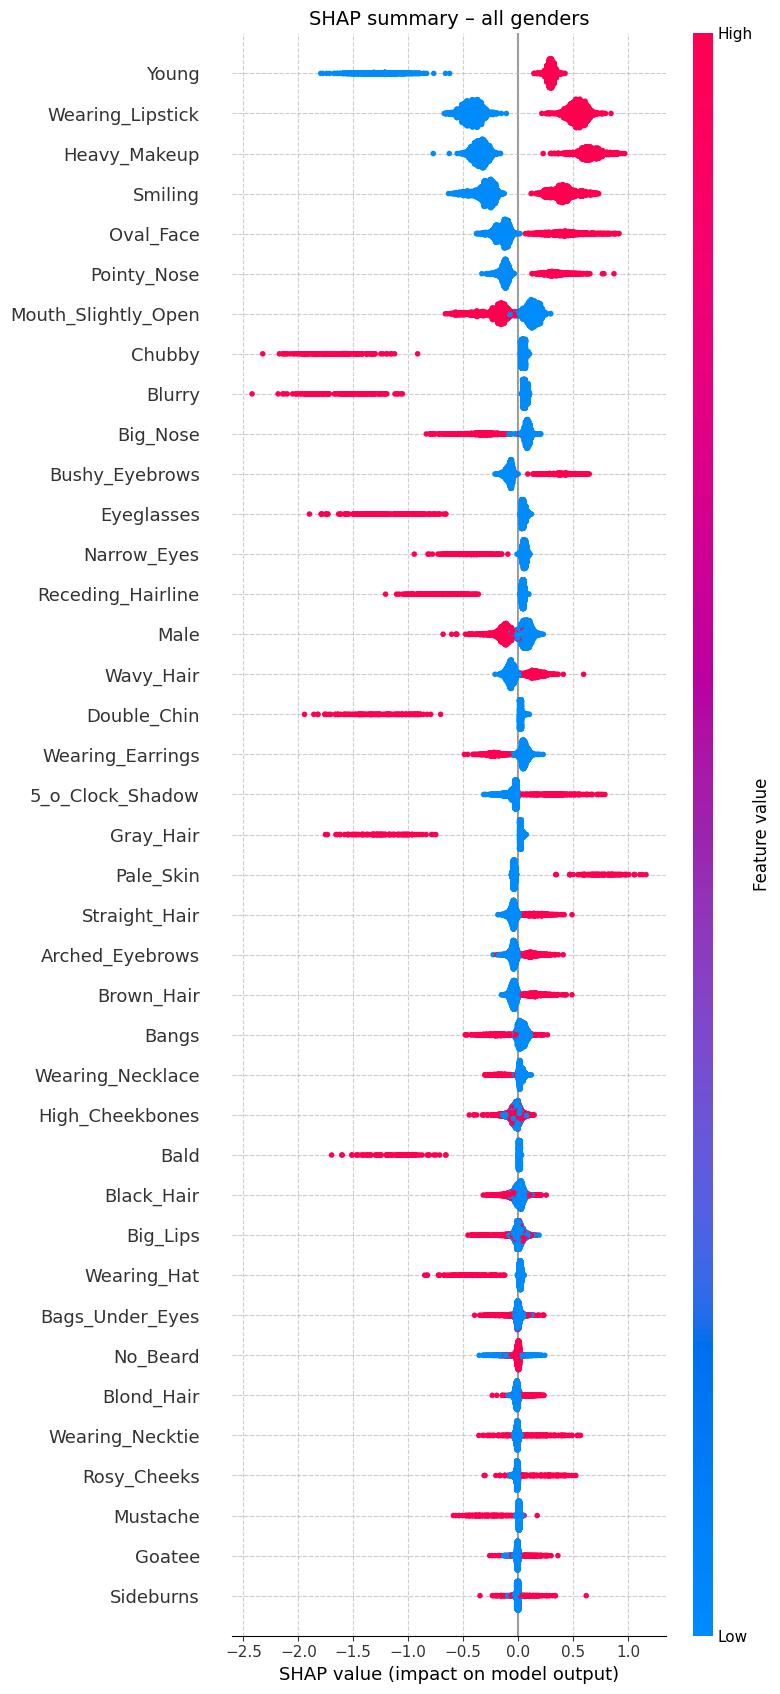

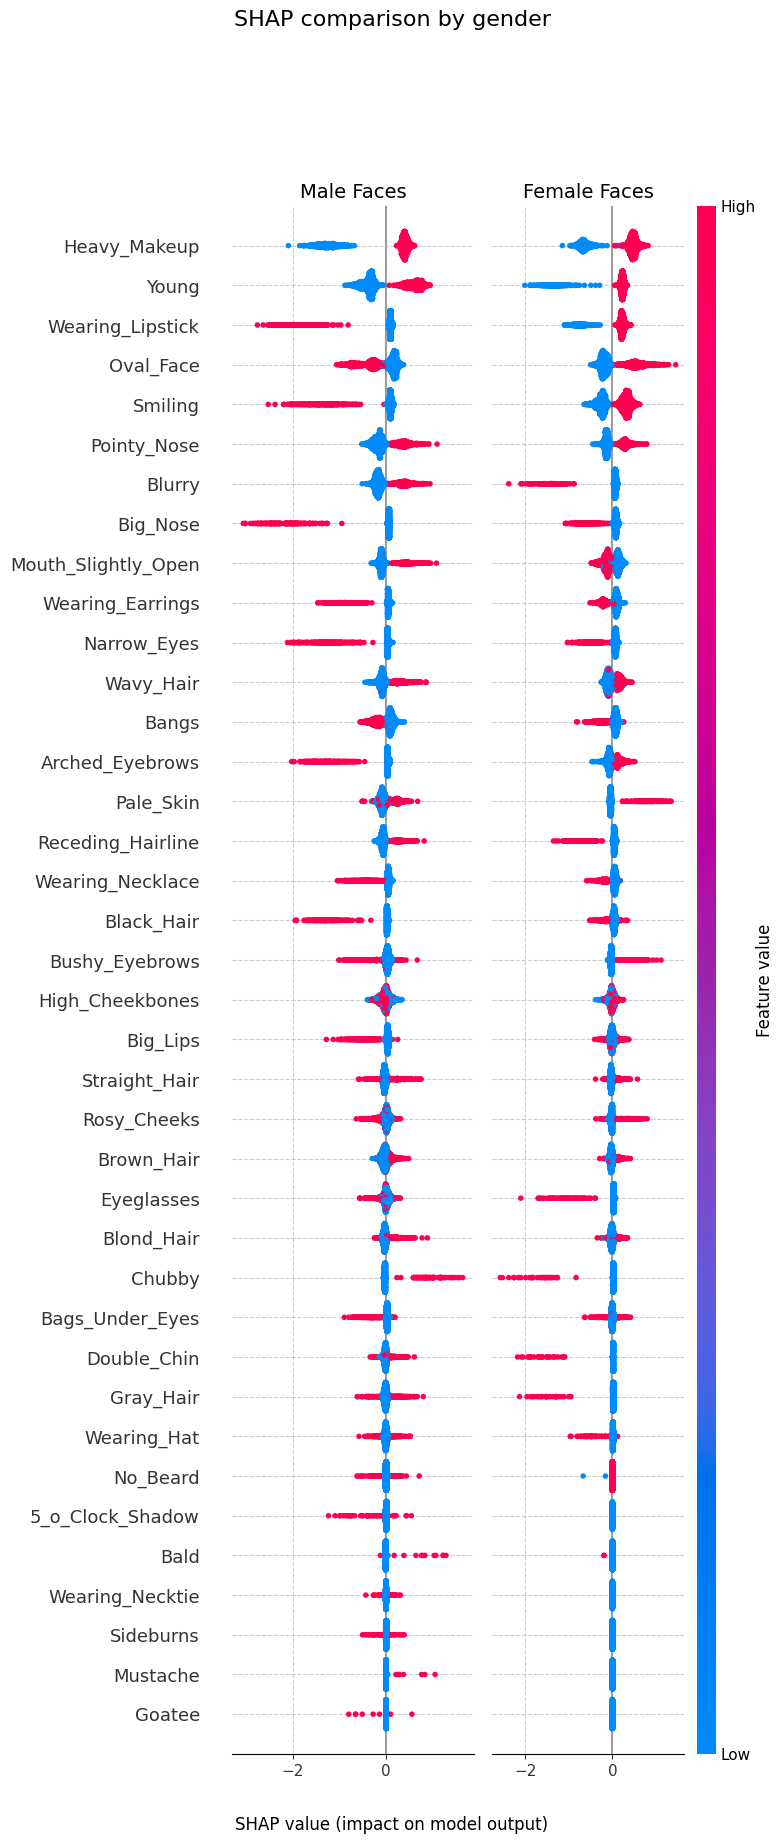

In [ ]:
shap.initjs()

# All-females and males summary
X_shap = X_test.sample(3000, random_state=42)
sv_all = shap.Explainer(final_model)(X_shap)

shap.summary_plot(
    sv_all.values,
    X_shap,
    feature_names=X_shap.columns,
    max_display=39,
    show=False
)
plt.title("SHAP summary – all genders")
plt.tight_layout(); plt.show()


# Females and males-specific SHAP values
X_male_test = X_test[X_test["Male"] == 1].drop(columns="Male")
X_male_shap = X_male_test.sample(min(3000, len(X_male_test)), random_state=42)
sv_male     = shap.Explainer(xgb_male)(X_male_shap)

X_fem_test  = X_test[X_test["Male"] == 0].drop(columns="Male")
X_fem_shap  = X_fem_test.sample(min(3000, len(X_fem_test)), random_state=42)
sv_fem      = shap.Explainer(xgb_female)(X_fem_shap)

# Side-by-side beeswarm plots
fig, (ax_m, ax_f) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))

plt.sca(ax_m)
shap.summary_plot(
    sv_male.values,
    X_male_shap,
    feature_names=X_male_shap.columns,
    max_display=39,
    show=False,
    color_bar=False
)
ax_m.set_title("Male Faces")
ax_m.set_xlabel("")

plt.sca(ax_f)
shap.summary_plot(
    sv_fem.values,
    X_fem_shap,
    feature_names=X_fem_shap.columns,
    max_display=39,
    show=False,
    color_bar=True
)
ax_f.set_title("Female Faces")
ax_f.set_xlabel("")

# One shared title and one shared x-axis label
fig.suptitle("SHAP comparison by gender", fontsize=16, y=1.07)
fig.text(0.5, -0.02, "SHAP value (impact on model output)", ha="center")

plt.tight_layout(); plt.show()